<a href="https://colab.research.google.com/github/Gio1709/paddy_100m_new/blob/master/Identifikasi_Lahan_Pertanian_300m_dan_Perbandingannya_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IDENTIFIKASI VEGETASI OTOMATIS DENGAN GAMBAR GOOGLE EARTH MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK**

# Preferensi

Penelitian Sebelumnya :
**Metode Convolutional Neural Network pada Gambar Google Earth Hutan Bambu di Jepang dengan .** 

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

link sebagai berikut : https://doi.org/10.1101/351643

**Note**

Penelitian ini mengambil konsep dari peneliti asal Jepang yang mengidentifikasikan vegatasi akurasi tinggi lahan hutan bamboo di beberapa wilayah Jepang, dengan klasisfikasi CNN, dan dilakukan dengan metode chopped-image.

Sedangkan pada penelitian ini memiliki konsep yang serupa dengan penelitian sebelumnya, akan tetapi mengambil sampel yang dilakukan lahan persawahan di Kabupaten Banyumas. 

Peneliti : Fendy Prayogi

Repositori tersedia pada : https://github.com/Gio1709/paddy


# Mengimpor/Mengambil Fungsi Library

In [1]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
import pandas as pd
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels



Using TensorFlow backend.


# Mengambil Dataset dari Github

In [0]:
# Mengambil dataset dari github

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_100/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_300/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy-coba/trunk/data/ > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_100m_new/trunk/data/ > /dev/null 

!apt-get install subversion > /dev/null
!svn export https://github.com/Gio1709/paddy_300m_new/trunk/data/ > /dev/null 

#!wget https://raw.githubusercontent.com/Gio1709/paddy/master/paddy.zip paddy.zip
#!unzip -P paddy paddy.zip


**Persiapan :**

*Program ini dibuat untuk mengidentifikasi lahan sawah dan luas di Kabupaten Banyumas*

File tersimpan dalam folder :
1. */chopped*
2. */train*
3. */test* 

# Mengimpor Datasheet

In [3]:
#Perintah untuk melihat list bagian dari file yang sudah diunduh dari Github

!ls data/paddy/train
!ls data/paddy/train/Jawa
!ls data/paddy/train/Kalimantan
!ls data/paddy/train/Sumatra
#gambar dengan nama awalan dengan "b" adalah gambar yang terdapat padi"
#gambar dengan nama awalan dengan "o" adalah gambar yang tidak terdapat padi"

Jawa  Kalimantan  Sumatra
b10.jpg  b16.jpg  b21.jpg  b3.jpg  b9.jpg   o15.jpg  o20.jpg  o2.jpg  o8.jpg
b11.jpg  b17.jpg  b22.jpg  b4.jpg  o10.jpg  o16.jpg  o21.jpg  o3.jpg  o9.jpg
b12.jpg  b18.jpg  b23.jpg  b5.jpg  o11.jpg  o17.jpg  o22.jpg  o4.jpg
b13.jpg  b19.jpg  b24.jpg  b6.jpg  o12.jpg  o18.jpg  o23.jpg  o5.jpg
b14.jpg  b1.jpg   b25.jpg  b7.jpg  o13.jpg  o19.jpg  o24.jpg  o6.jpg
b15.jpg  b20.jpg  b2.jpg   b8.jpg  o14.jpg  o1.jpg   o25.jpg  o7.jpg
b26.jpg  b32.jpg  b38.jpg  b44.jpg  b50.jpg  o31.jpg  o37.jpg  o43.jpg	o49.jpg
b27.jpg  b33.jpg  b39.jpg  b45.jpg  o26.jpg  o32.jpg  o38.jpg  o44.jpg	o50.jpg
b28.jpg  b34.jpg  b40.jpg  b46.jpg  o27.jpg  o33.jpg  o39.jpg  o45.jpg
b29.jpg  b35.jpg  b41.jpg  b47.jpg  o28.jpg  o34.jpg  o40.jpg  o46.jpg
b30.jpg  b36.jpg  b42.jpg  b48.jpg  o29.jpg  o35.jpg  o41.jpg  o47.jpg
b31.jpg  b37.jpg  b43.jpg  b49.jpg  o30.jpg  o36.jpg  o42.jpg  o48.jpg
b51.jpg  b57.jpg  b63.jpg  b69.jpg  b75.jpg  o56.jpg  o62.jpg  o68.jpg	o74.jpg
b52.jpg  b58.jpg  b64.j

#Menampilkan Gambar Pelatihan

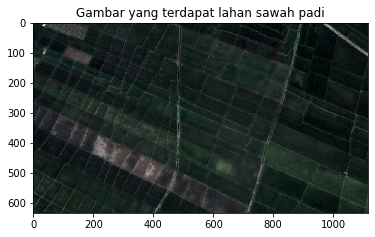

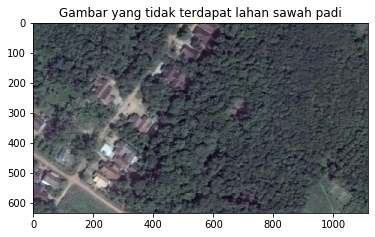

In [8]:
#Gambar yang terdapat lahan sawah padi
plt.title("Gambar yang terdapat lahan sawah padi")
plt.imshow(imread("data/paddy/train/Jawa/b10.jpg"))
plt.show()

#Gambar yang terdapat tidak lahan sawah padi
plt.title("Gambar yang tidak terdapat lahan sawah padi")
plt.imshow(imread("data/paddy/train/Sumatra/o51.jpg"))
plt.show()


# Membuat "patches" dari setiap gambar menggunakan metode sliding window

**Apa itu *Sliding Window* ?**

*Sliding window* adalah window yang bergeser untuk memprediksi dan mencari area objek yang benar. Suatu proses deteksi objek memerlukan teknik lokalisasi 
untuk menemukan area objek. 



In [9]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)

files = os.listdir("data/paddy/train/Jawa")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "data/paddy/chopped/Jawa"
    file = os.path.join("data/paddy/train/Jawa",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/b15_00000.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/b15_00001.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/b15_00007.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/b15_00010.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/b15_00011.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/choppe

In [10]:
files = os.listdir("data/paddy/train/Kalimantan")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "data/paddy/chopped/Kalimantan"
    file = os.path.join("data/paddy/train/Kalimantan",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/o36_00050.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/o36_00069.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/o36_00072.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/o36_00122.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/o36_00140.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: 

In [11]:
files = os.listdir("data/paddy/train/Sumatra")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "data/paddy/chopped/Sumatra"
    file = os.path.join("data/paddy/train/Sumatra",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b52_00000.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b52_00001.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b52_00002.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b52_00003.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b52_00004.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: da

# Dataset Pelatihan dari 3 Pulau Berbeda
Terdapat 3 dataset yang digunakan dalam Model Performa Klasifikasi akurasi, Recall Rate dan Presisi. Data pelatihan yang telah dichop sehingga menghasilkan gambar baru, lalu kita klasifikasikan hasilnya dengan empat kategori berupa :  *true positive* (TP), *false positive* (FP), *false negative* (FN), dan *true negative* (TN). 
Dengan ketentuan prediksi benar atau salah dan gambar sawah atau bukan sawah. Pada Gambar Sawah dilabeli dengan nama huruf "b" dan ada gambar bukan sawah dilabeli dengan nama huruf "o".

**Pulau Jawa**

In [12]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Dataset Pulau Jawa
files = os.listdir("data/paddy/chopped/Jawa")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("data/paddy/chopped/Jawa",file)
    #img_path = os.path.join("data/paddy/chopped/Kalimantan",file)
    #img_path = os.path.join("data/paddy/chopped/Sumatra",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
X = x.reshape(x.shape[0], -1)
Y = np.array(y)
print("Dataset Pula Jawa")
print("Bentuk array dari dataset train (pelatihan) adalah :", (X.shape,Y.shape))

files= pd.Index(files)
print("Tampilan list gambar yang telah dichop :\n",files.value_counts())

Dataset Pula Jawa
Bentuk array dari dataset train (pelatihan) adalah : ((29700, 9408), (29700,))
Tampilan list gambar yang telah dichop :
 b10_00207.jpg    1
b24_00029.jpg    1
b21_00579.jpg    1
o8_00536.jpg     1
o13_00336.jpg    1
                ..
o11_00147.jpg    1
b23_00591.jpg    1
b11_00264.jpg    1
b16_00298.jpg    1
b22_00355.jpg    1
Length: 29700, dtype: int64


**Pulau Kalimantan**

In [13]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Dataset Pulau Kalimantan
files = os.listdir("data/paddy/chopped/Kalimantan")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x1 = []
y1 = []

for file in files:
    if file.startswith("b"):
        label1 = 1
    else:
        label1 = 0
    
    img_path1 = os.path.join("data/paddy/chopped/Kalimantan",file)
    #img_path1 = os.path.join("data/paddy/chopped/Kalimantan",file)
    #img_path1 = os.path.join("data/paddy/chopped/Sumatra",file)
    img1 = load_img(img_path1)
    img1 = img_to_array(img1)/255
    x1.append(img1)
    y1.append(label1)

x1 = np.array(x1)
X1 = x1.reshape(x1.shape[0], -1)
Y1 = np.array(y1)
print("Dataset Pula Kalimantan")
print("Bentuk array dari dataset train (pelatihan) adalah :", (X1.shape,Y1.shape))

files= pd.Index(files)
print("Tampilan list gambar yang telah dichop :\n",files.value_counts())

Dataset Pula Kalimantan
Bentuk array dari dataset train (pelatihan) adalah : ((29700, 9408), (29700,))
Tampilan list gambar yang telah dichop :
 b47_00324.jpg    1
o36_00318.jpg    1
o26_00014.jpg    1
b30_00546.jpg    1
b27_00339.jpg    1
                ..
b39_00563.jpg    1
b29_00021.jpg    1
o35_00131.jpg    1
b46_00426.jpg    1
b35_00509.jpg    1
Length: 29700, dtype: int64


**Pulau Sumatra**

In [14]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Dataset Pulau Jawa
#files = os.listdir("data/paddy/chopped/Jawa")
#files = [x for x in files if x.endswith(".jpg")]

#Dataset Pulau Kalimantan
#files = os.listdir("data/paddy/chopped/Kalimantan")
#files = [x for x in files if x.endswith(".jpg")]

#Dataset Pulau Sumatra
files = os.listdir("data/paddy/chopped/Sumatra")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x2 = []
y2 = []

for file in files:
    if file.startswith("b"):
        label2 = 1
    else:
        label2 = 0
    
    img_path2 = os.path.join("data/paddy/chopped/Sumatra",file)
    img2 = load_img(img_path2)
    img2 = img_to_array(img2)/255
    x2.append(img2)
    y2.append(label2)

x2 = np.array(x2)
X2 = x2.reshape(x2.shape[0], -1)
Y2 = np.array(y2)
print("Dataset Pula Kalimantan")
print("Bentuk array dari dataset train (pelatihan) adalah :", (X2.shape,Y2.shape))

files= pd.Index(files)
print("Tampilan list gambar yang telah dichop :\n",files.value_counts())

Dataset Pula Kalimantan
Bentuk array dari dataset train (pelatihan) adalah : ((29700, 9408), (29700,))
Tampilan list gambar yang telah dichop :
 b62_00424.jpg    1
b62_00082.jpg    1
o58_00021.jpg    1
o62_00533.jpg    1
o73_00207.jpg    1
                ..
b61_00397.jpg    1
b66_00187.jpg    1
o51_00312.jpg    1
o51_00152.jpg    1
b54_00354.jpg    1
Length: 29700, dtype: int64


In [0]:
# Membagi X dan Y kedalam data pelatihan dan testing
from sklearn.model_selection import train_test_split
X_train, test_x, y_train, test_y = train_test_split(X, Y, random_state=0)
X_train1, test_x1, y_train1, test_y1 = train_test_split(X1, Y1, random_state=0)
X_train2, test_x2, y_train2, test_y2 = train_test_split(X2, Y2, random_state=0)

In [16]:
print(X_train, y_train)
print(X_train.shape, y_train.shape)
print(test_x, test_y)
print(test_x.shape, test_y.shape)
print(X_train1, y_train1)
print(X_train1.shape, y_train1.shape)
print(test_x1, test_y1)
print(test_x1.shape, test_y1.shape)
print(X_train2, y_train2)
print(X_train2.shape, y_train2.shape)
print(test_x2, test_y2)
print(test_x2.shape, test_y2.shape)

[[0.43529412 0.43137255 0.4509804  ... 0.34901962 0.31764707 0.36862746]
 [0.36078432 0.30588236 0.30588236 ... 0.21960784 0.27058825 0.23529412]
 [0.34901962 0.4862745  0.39215687 ... 0.5254902  0.5372549  0.47058824]
 ...
 [0.12941177 0.19215687 0.18039216 ... 0.14117648 0.20784314 0.18431373]
 [0.04313726 0.06666667 0.06666667 ... 0.08235294 0.15686275 0.14117648]
 [0.19215687 0.27450982 0.21568628 ... 0.19215687 0.2627451  0.21568628]] [0 0 0 ... 1 1 1]
(22275, 9408) (22275,)
[[0.07450981 0.14901961 0.13333334 ... 0.05490196 0.13725491 0.11764706]
 [0.08235294 0.11764706 0.11372549 ... 0.10196079 0.16078432 0.13333334]
 [0.07058824 0.1254902  0.1254902  ... 0.26666668 0.23137255 0.24313726]
 ...
 [0.02352941 0.04705882 0.03921569 ... 0.14117648 0.21568628 0.14117648]
 [0.21568628 0.21568628 0.21568628 ... 0.05098039 0.10980392 0.09019608]
 [0.50980395 0.45882353 0.4862745  ... 0.5764706  0.4        0.41960785]] [1 1 1 ... 1 1 0]
(7425, 9408) (7425,)
[[0.27450982 0.3254902  0.290196

In [17]:
# Pelatihan model logistic regression pada set training
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)
logreg.fit(X_train1, y_train1)
logreg.fit(X_train2, y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Membuat class predictions pada testing set
y_pred_class = logreg.predict(test_x)
y_pred_class1 = logreg.predict(test_x1)
y_pred_class2 = logreg.predict(test_x2)

In [19]:
# Mengkalkulasi accuracy
from sklearn import metrics
print("Akurasi pada data Pulau Jawa:",metrics.accuracy_score(test_y, y_pred_class))
print("Akurasi pada data Pulau Kalimantan:",metrics.accuracy_score(test_y1, y_pred_class1))
print("Akurasi pada data Pulau Sumatra:",metrics.accuracy_score(test_y2, y_pred_class2))

Akurasi pada data Pulau Jawa: 0.6855218855218855
Akurasi pada data Pulau Kalimantan: 0.5198653198653199
Akurasi pada data Pulau Sumatra: 0.7609427609427609


In [20]:
# Mengetahui class berdasarkan gambar sawah dan bukan sawah 
# Apabila 1 menandakan gambar sawah dan 0 bukan sawah 

test_Y = pd.Index(test_y)
print("Class dan jumlah data Pulau Jawa:\n Class Jumlah \n",test_Y.value_counts())
print("\n")
test_Y1 = pd.Index(test_y1)
print("Class dan jumlah data Pulau Kalimantan:\n Class Jumlah \n",test_Y1.value_counts())
print("\n")
test_Y2 = pd.Index(test_y2)
print("Class dan jumlah data Pulau Kalimantan:\n Class Jumlah \n",test_Y2.value_counts())

Class dan jumlah data Pulau Jawa:
 Class Jumlah 
 0    3734
1    3691
dtype: int64


Class dan jumlah data Pulau Kalimantan:
 Class Jumlah 
 0    3730
1    3695
dtype: int64


Class dan jumlah data Pulau Kalimantan:
 Class Jumlah 
 1    3756
0    3669
dtype: int64


In [0]:
# calculate the percentage of ones
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
#print(test_y.mean())
#print(test_y1.mean())
#print(test_y2.mean())

# calculate the percentage of zeros
#print(1 - test_y.mean())
#print(1 - test_y1.mean())
#print(1 - test_y2.mean())

# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
#print(max(test_y.mean(), 1 - test_y.mean()))
#print(max(test_y1.mean(), 1 - test_y1.mean()))
#print(max(test_y2.mean(), 1 - test_y2.mean()))

# calculate null accuracy (for multi-class classification problems)
#print(test_Y.value_counts().head(1) / len(test_y))
#print(test_Y1.value_counts().head(1) / len(test_y1))
#print(test_Y2.value_counts().head(1) / len(test_y2))

In [22]:
# Menampilkan 25 data pertama/awal true atau pun prediksi 
print("Dataset Pulau Jawa:")
print('True:', test_Y.values[0:25])
print('False:', y_pred_class[0:25])
print("\n")
print("Dataset Pulau Kalimantan:")
print('True:', test_Y1.values[0:25])
print('False:', y_pred_class1[0:25])
print("\n")
print("Dataset Pulau Sumatra:")
print('True:', test_Y2.values[0:25])
print('False:', y_pred_class2[0:25])

Dataset Pulau Jawa:
True: [1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0]
False: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1]


Dataset Pulau Kalimantan:
True: [1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1]
False: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Dataset Pulau Sumatra:
True: [1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0]
False: [1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0]


In [23]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(test_y, y_pred_class)
print("Matriks hasil clasification Pulau Jawa:\n",confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion1 = metrics.confusion_matrix(test_y1, y_pred_class1)
print("Matriks hasil clasification Pulau Kalimantan:\n",confusion1)
#[row, column]
TP1 = confusion1[1, 1]
TN1 = confusion1[0, 0]
FP1 = confusion1[0, 1]
FN1 = confusion1[1, 0]

# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion2 = metrics.confusion_matrix(test_y2, y_pred_class2)
print("Matriks hasil clasification Pulau Sumatra:\n",confusion2)
#[row, column]
TP2 = confusion2[1, 1]
TN2 = confusion2[0, 0]
FP2 = confusion2[0, 1]
FN2 = confusion2[1, 0]

Matriks hasil clasification Pulau Jawa:
 [[1433 2301]
 [  34 3657]]
Matriks hasil clasification Pulau Kalimantan:
 [[ 203 3527]
 [  38 3657]]
Matriks hasil clasification Pulau Sumatra:
 [[2761  908]
 [ 867 2889]]


Classification accuracy Pulau Jawa: 0.6855218855218855
Classification accuracy Pulau Kalimantan: 0.5198653198653199
Classification accuracy Pulau Sumatra: 0.7609427609427609


Text(0, 0.5, 'Accuracy')

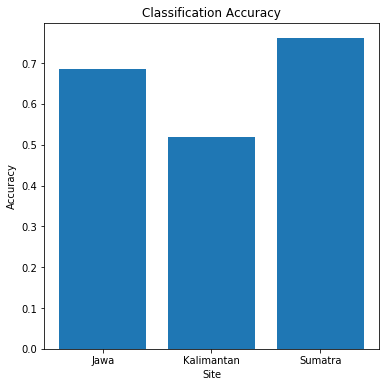

In [24]:
# Classification accuracy dari ketiga pulau 
#print((TP + TN) / float(TP + TN + FP + FN))
print("Classification accuracy Pulau Jawa:",metrics.accuracy_score(test_y, y_pred_class))

#print((TP1 + TN1) / float(TP1 + TN1 + FP1 + FN1))
print("Classification accuracy Pulau Kalimantan:",metrics.accuracy_score(test_y1, y_pred_class1))

#print((TP2 + TN2) / float(TP2 + TN2 + FP2 + FN2))
print("Classification accuracy Pulau Sumatra:",metrics.accuracy_score(test_y2, y_pred_class2))

import matplotlib.pyplot as plt

data = {'Jawa': metrics.accuracy_score(test_y, y_pred_class), 'Kalimantan': metrics.accuracy_score(test_y1, y_pred_class1), 'Sumatra': metrics.accuracy_score(test_y2, y_pred_class2)}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
axs.bar(names, values)

plt.title('Classification Accuracy')
plt.xlabel('Site')
plt.ylabel('Accuracy')

In [25]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
#print(classification_error)
#print(1 - metrics.accuracy_score(test_y, y_pred_class))
print("Classification error Pulau Jawa:",1 - metrics.accuracy_score(test_y, y_pred_class))

classification_error1 = (FP1 + FN1) / float(TP1 + TN1 + FP1 + FN1)
#print(classification_error1)
print("Classification error Pulau Kalimantan:",1 - metrics.accuracy_score(test_y1, y_pred_class1))

classification_error = (FP2 + FN2) / float(TP2 + TN2 + FP2 + FN2)
#print(classification_error)
print("Classification error Pulau Sumatra:",1 - metrics.accuracy_score(test_y2, y_pred_class2))

Classification error Pulau Jawa: 0.31447811447811447
Classification error Pulau Kalimantan: 0.4801346801346801
Classification error Pulau Sumatra: 0.23905723905723908


Recall Rate Sawah Pulau Jawa: 0.9907884042264968
Recall Rate Sawah Pulau Kalimantan: 0.9897158322056834
Recall Rate Sawah Pulau Sumatra: 0.7691693290734825


Text(0, 0.5, 'Recall Rate')

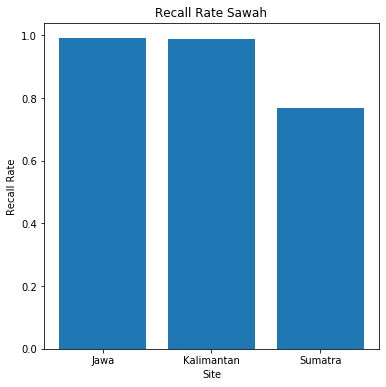

In [26]:
recall_rate_sawah = TP / float(FN + TP)

print("Recall Rate Sawah Pulau Jawa:",recall_rate_sawah)
#print(metrics.recall_score(test_y, y_pred_class))

recall_rate_sawah1 = TP1 / float(FN1 + TP1)

print("Recall Rate Sawah Pulau Kalimantan:",recall_rate_sawah1)
#print(metrics.recall_score(test_y1, y_pred_class1))

recall_rate_sawah2 = TP2 / float(FN2 + TP2)

print("Recall Rate Sawah Pulau Sumatra:",recall_rate_sawah2)
#print(metrics.recall_score(test_y2, y_pred_class2))

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': recall_rate_sawah, 'Kalimantan': recall_rate_sawah1, 'Sumatra': recall_rate_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

Recall Rate Bukan Sawah Pulau Jawa: 0.3837707552222817
Recall Rate Bukan Sawah Pulau Kalimantan: 0.05442359249329759
Recall Rate Bukan Sawah Pulau Sumatra: 0.7525211229217771


Text(0, 0.5, 'Recall Rate')

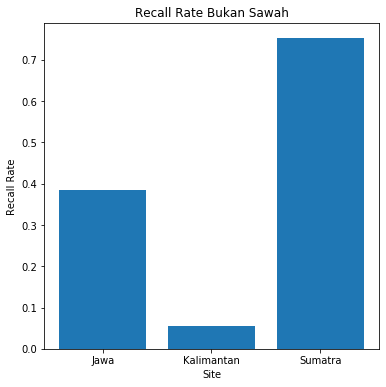

In [27]:
recall_rate_bukan_sawah = TN / (TN + FP)
print("Recall Rate Bukan Sawah Pulau Jawa:",recall_rate_bukan_sawah)

recall_rate_bukan_sawah1 = TN1 / (TN1 + FP1)
print("Recall Rate Bukan Sawah Pulau Kalimantan:",recall_rate_bukan_sawah1)

recall_rate_bukan_sawah2 = TN2 / (TN2 + FP2)
print("Recall Rate Bukan Sawah Pulau Sumatra:",recall_rate_bukan_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': recall_rate_bukan_sawah, 'Kalimantan': recall_rate_bukan_sawah1, 'Sumatra': recall_rate_bukan_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Bukan Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

In [28]:
false_positive_rate = FP / float(TN + FP)
#print(false_positive_rate)
print("false positive rate Pulau Jawa:",1 - recall_rate_bukan_sawah)

false_positive_rate1 = FP1 / float(TN1 + FP1)
#print(false_positive_rate1)
print("false positive rate Pulau Kalimantan:",1 - recall_rate_bukan_sawah1)

false_positive_rate2 = FP2 / float(TN2 + FP2)
#print(false_positive_rate2)
print("false positive rate Pulau Sumatra:",1 - recall_rate_bukan_sawah2)

false positive rate Pulau Jawa: 0.6162292447777182
false positive rate Pulau Kalimantan: 0.9455764075067024
false positive rate Pulau Sumatra: 0.24747887707822291


Precision Sawah Pulau Jawa: 0.6137965760322256
Precision Sawah Pulau Kalimantan: 0.5090478841870824
Precision Sawah Pulau Sumatra: 0.7608638398735844


Text(0, 0.5, 'Recall Rate')

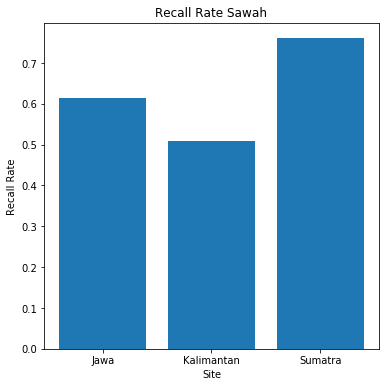

In [29]:
precision_sawah = TP / float(TP + FP)
print("Precision Sawah Pulau Jawa:",precision_sawah)

precision_sawah1 = TP1 / float(TP1 + FP1)
print("Precision Sawah Pulau Kalimantan:",precision_sawah1)

precision_sawah2 = TP2 / float(TP2 + FP2)
print("Precision Sawah Pulau Sumatra:",precision_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': precision_sawah, 'Kalimantan': precision_sawah1, 'Sumatra': precision_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

Precision Bukan Sawah Pulau Jawa: 0.24051695199731454
Precision Bukan Sawah Pulau Kalimantan: 0.028257238307349667
Precision Bukan Sawah Pulau Sumatra: 0.7271530155385831


Text(0, 0.5, 'Recall Rate')

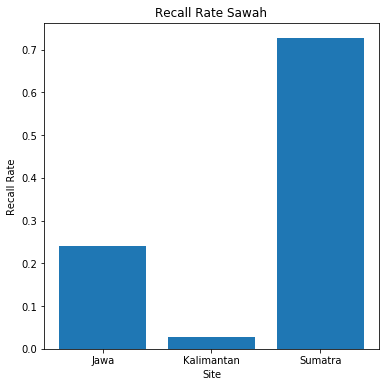

In [30]:
precision_bukan_sawah = TN / (FP + TP)
print("Precision Bukan Sawah Pulau Jawa:",precision_bukan_sawah)

precision_bukan_sawah1 = TN1 / (FP1 + TP1)
print("Precision Bukan Sawah Pulau Kalimantan:",precision_bukan_sawah1)

precision_bukan_sawah2 = TN2 / (FP2 + TP2)
print("Precision Bukan Sawah Pulau Sumatra:",precision_bukan_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': precision_bukan_sawah, 'Kalimantan': precision_bukan_sawah1, 'Sumatra': precision_bukan_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

In [31]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,Y,test_size=0.0008,stratify = y)

print("Bentuk array dari dataset train (pelatihan) adalah:",train_x.shape,train_y.shape)
print("Bentuk array dari dataset validation adalah:",valid_x.shape,valid_y.shape)
#print("Bentuk array dari dataset test (pengujian) adalah:",x_test.shape,y_test.shape)

Bentuk array dari dataset train (pelatihan) adalah: (29676, 56, 56, 3) (29676,)
Bentuk array dari dataset validation adalah: (24, 56, 56, 3) (24,)


In [32]:
#Mengkomputasi kelas bobotnya
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight("balanced",np.unique(train_y),train_y)
print(cw)

(array([0, 1]), array([14838, 14838]))
(array([0, 1]), array([12, 12]))
[1. 1.]


#Pembuatan Model

In [0]:
import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [34]:
IMG_SHAPE = (56, 56, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 6s 0us/step


In [35]:
base_model.trainable = True
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [36]:
model1 = tf.keras.Sequential([
    base_model,  
    tf.keras.layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    #tf.keras.layers.MaxPool2D((2,2),name="pool1"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool2"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.05),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    #layers.Dropout(0.05),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation("sigmoid",name="prediction")
]
)

model1.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model1.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 1, 16)          73744     
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 1, 32)          4640      
_________________________________________________________________
activation (Activation)      (None, 1, 1, 32)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 1, 32)          9248      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1, 32)          0         
____________________________

In [37]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan model bobot yang terbaik selama training
ckpt = ModelCheckpoint("paddy.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model1.fit(train_x,train_y,batch_size=2000,epochs=20,validation_data=(valid_x,valid_y),class_weight=cw, callbacks = [ckpt])

Train on 29676 samples, validate on 24 samples
Epoch 1/20
28000/29676 [===========================>..] - ETA: 1s - loss: 0.8878 - acc: 0.4994
Epoch 00001: val_loss improved from inf to 0.68974, saving model to paddy.h5
29676/29676 [==============================] - 33s 1ms/sample - loss: 0.8766 - acc: 0.4994 - val_loss: 0.6897 - val_acc: 0.5000
Epoch 2/20
28000/29676 [===========================>..] - ETA: 0s - loss: 0.7029 - acc: 0.5076
Epoch 00002: val_loss did not improve from 0.68974
29676/29676 [==============================] - 14s 484us/sample - loss: 0.7022 - acc: 0.5073 - val_loss: 0.6922 - val_acc: 0.5000
Epoch 3/20
28000/29676 [===========================>..] - ETA: 0s - loss: 0.6919 - acc: 0.5002
Epoch 00003: val_loss improved from 0.68974 to 0.68738, saving model to paddy.h5
29676/29676 [==============================] - 15s 494us/sample - loss: 0.6919 - acc: 0.5001 - val_loss: 0.6874 - val_acc: 0.9167
Epoch 4/20
28000/29676 [===========================>..] - ETA: 0s - los

#Menggambarkan Hasil Pelatihan

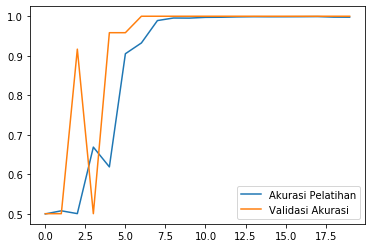

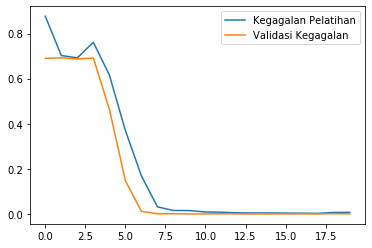

In [38]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

In [39]:
import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

IMAGE_SIZE = 56
BATCH_SIZE = 2000
base_dir = os.path.join('data/paddy/chopped')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.00029)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian

X_test = []
Y_test = []
labels1 = ['Jawa', 'Kalimantan', 'Sumatra']

for i,label1 in enumerate(labels1):
    folder1 = os.path.join("data/paddy/test",label1)
    files1 = os.listdir(folder1)
    files1 = [x for x in files1 if x.endswith(".jpg")]
    for k,file in enumerate(files1):
        image_path1 = os.path.join(folder1, file)   
        image1 = imread(image_path1)/255.
        image1 = resize(image1,(56,56))
        X_test.append(image1)
        category = os.path.split(folder1)[-1]
        Y_test.append(i)

x_test = np.array(X_test)
y_test = np.array(Y_test)
print(x_test.shape,y_test.shape)

for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", x_test.shape,y_test.shape)

Found 89076 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
(24, 56, 56, 3) (24,)
Bentuk array dari dataset train (pelatihan) adalah: (2000, 56, 56, 3) (2000, 3)
Bentuk array dari dataset validation (validasi) adalah: (24, 56, 56, 3) (24, 3)
Bentuk array dari dataset test (pengujian) adalah: (24, 56, 56, 3) (24,)


# Menyimpan Label

In [40]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Jawa': 0, 'Kalimantan': 1, 'Sumatra': 2}


In [41]:
!cat labels.txt

Jawa
Kalimantan
Sumatra

# Membuat Pemodelan dan Pelatihan Model

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

#Pembuatan Model


In [0]:
IMG_SHAPE = (56, 56, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

## *Feature Extraction*

Menggunakan model pre-trained untuk ekstraksi fitur (feature extraction) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat contoh model pre-trained dan menambahkan classifier yang sepenuhnya terhubung di atas. Model pre-trained adalah "beku" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusional mengekstraksi semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih classifier yang menentukan kelas gambar mengingat set fitur yang diekstraksi.

In [43]:
base_model.trainable = True
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

# Mengelompokkan Klasifikasi Tiga Pulau dengan *Deep learning* (*Convolutional Neural Network*)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

## Mempersiapkan Data Masukkan Pengujian

In [0]:
y_test2 = to_categorical(y_test)
x_test3, y_test3 = (x_test, y_test2)

In [46]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    #tf.keras.layers.MaxPool2D((2,2),name="pool1"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool2"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.05),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    #layers.Dropout(0.05),
    tf.keras.layers.Dense(3),
    tf.keras.layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 1, 16)          73744     
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 1, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 1, 32)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 1, 32)          9248      
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)               

In [47]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint 

#Menyimpan model bobot yang terbaik selama training
#ckpt = ModelCheckpoint("paddy.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history1 = model.fit_generator(train_generator, 
                    epochs=20, 
                    validation_data=val_generator)
#history = model.fit(train_x,train_y,batch_size=200,epochs=100,validation_data=(valid_x,valid_y),class_weight=cw, callbacks = [ckpt])

Epoch 1/20
45/45 [==============================] - 81s 2s/step - loss: 0.6868 - acc: 0.6640 - val_loss: 0.6351 - val_acc: 0.6667
Epoch 2/20
45/45 [==============================] - 42s 939ms/step - loss: 0.6403 - acc: 0.6667 - val_loss: 0.6288 - val_acc: 0.6667
Epoch 3/20
45/45 [==============================] - 42s 935ms/step - loss: 0.6379 - acc: 0.6714 - val_loss: 0.5536 - val_acc: 0.7500
Epoch 4/20
45/45 [==============================] - 42s 938ms/step - loss: 0.6212 - acc: 0.6797 - val_loss: 0.6378 - val_acc: 0.6667
Epoch 5/20
45/45 [==============================] - 42s 938ms/step - loss: 0.6369 - acc: 0.6667 - val_loss: 0.6372 - val_acc: 0.6667
Epoch 6/20
45/45 [==============================] - 42s 937ms/step - loss: 0.6363 - acc: 0.6667 - val_loss: 0.6366 - val_acc: 0.6667
Epoch 7/20
45/45 [==============================] - 42s 936ms/step - loss: 0.6358 - acc: 0.6667 - val_loss: 0.6353 - val_acc: 0.6667
Epoch 8/20
45/45 [==============================] - 42s 936ms/step - los

#Menggambarkan Hasil Pelatihan

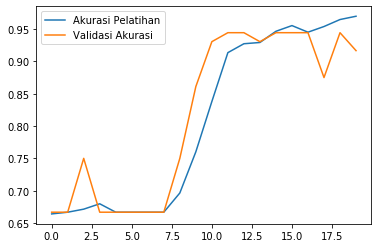

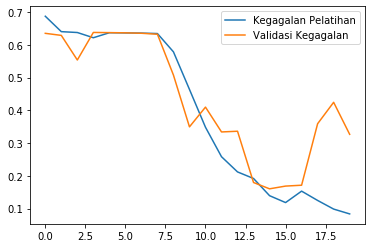

In [48]:
plt.plot(history1.history["acc"],label="Akurasi Pelatihan")
plt.plot(history1.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history1.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history1.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

# Evaluasi dengan model


In [49]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi test data
#print(model.evaluate(x= x_test3, y = y_test3))

['loss', 'acc']
45/45 [==============================] - 26s 576ms/step - loss: 0.0802 - acc: 0.9742
[0.08016276790036095, 0.9741681]
1/1 [==============================] - 0s 27ms/step - loss: 0.3267 - acc: 0.9167
[0.3266625702381134, 0.9166667]


In [50]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
[0 0 1 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 1 1 0 0 1 0]


Normalized confusion matrix
[[0.88 0.12 0.  ]
 [0.75 0.12 0.12]
 [0.62 0.38 0.  ]]


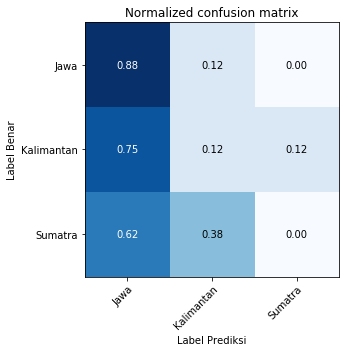

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels1, normalize=True,
                      title='Normalized confusion matrix')

# Evaluasi Gambar Pelatihan dengan Gambar Test data

In [0]:
#Memuat file bobot model keras ".h5" dengan paling sedikit data validasi yang hilang/error
#File ini akan dikonversi ke tensorflow lite
model1.load_weights("paddy.h5")

In [53]:
print(X_train, y_train)
print(X_train.shape, y_train.shape)
print(test_x, test_y)
print(test_x.shape, test_y.shape)
print(X_train1, y_train1)
print(X_train1.shape, y_train1.shape)
print(test_x1, test_y1)
print(test_x1.shape, test_y1.shape)
print(X_train2, y_train2)
print(X_train2.shape, y_train2.shape)
print(test_x2, test_y2)
print(test_x2.shape, test_y2.shape)

[[0.44 0.43 0.45 ... 0.35 0.32 0.37]
 [0.36 0.31 0.31 ... 0.22 0.27 0.24]
 [0.35 0.49 0.39 ... 0.53 0.54 0.47]
 ...
 [0.13 0.19 0.18 ... 0.14 0.21 0.18]
 [0.04 0.07 0.07 ... 0.08 0.16 0.14]
 [0.19 0.27 0.22 ... 0.19 0.26 0.22]] [0 0 0 ... 1 1 1]
(22275, 9408) (22275,)
[[0.07 0.15 0.13 ... 0.05 0.14 0.12]
 [0.08 0.12 0.11 ... 0.1  0.16 0.13]
 [0.07 0.13 0.13 ... 0.27 0.23 0.24]
 ...
 [0.02 0.05 0.04 ... 0.14 0.22 0.14]
 [0.22 0.22 0.22 ... 0.05 0.11 0.09]
 [0.51 0.46 0.49 ... 0.58 0.4  0.42]] [1 1 1 ... 1 1 0]
(7425, 9408) (7425,)
[[0.27 0.33 0.29 ... 0.38 0.42 0.38]
 [0.41 0.42 0.4  ... 0.35 0.37 0.35]
 [0.41 0.39 0.35 ... 0.32 0.33 0.26]
 ...
 [0.2  0.24 0.21 ... 0.15 0.21 0.16]
 [0.3  0.35 0.32 ... 0.27 0.33 0.29]
 [0.28 0.34 0.32 ... 0.31 0.35 0.32]] [1 1 0 ... 0 0 1]
(22275, 9408) (22275,)
[[0.3  0.35 0.32 ... 0.28 0.34 0.32]
 [0.29 0.33 0.32 ... 0.31 0.36 0.34]
 [0.18 0.21 0.2  ... 0.22 0.28 0.26]
 ...
 [0.25 0.31 0.27 ... 0.24 0.3  0.27]
 [0.29 0.35 0.33 ... 0.27 0.31 0.27]
 [0.3

In [54]:
#Memeriksa matriks model
print(model1.metrics_names)
#Evaluasi data training
print(model1.evaluate(x= train_x, y = train_y))
#Evaluasi validasi data
print(model1.evaluate(x= valid_x, y = valid_y))

['loss', 'acc']
29676/29676 [==============================] - 9s 315us/sample - loss: 0.0015 - acc: 0.9996
[0.0015035130829598245, 0.99959564]
24/24 [==============================] - 0s 391us/sample - loss: 4.4131e-06 - acc: 1.0000
[4.413116130308481e-06, 1.0]


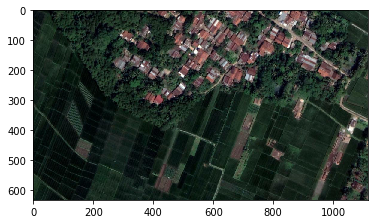

27
1296 27 48


In [55]:
#Membaca Gambar Test Data dan Menampilkannya
img_path = "data/paddy/test/test_image/test_image4.jpg"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

In [56]:
print(patches.shape)

(1296, 56, 56, 3)


#Prediksi Gambar Individual

(1296, 1)
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


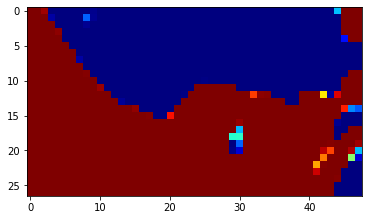

In [57]:
#Memprediksi probalititas keberadaaan lahan sawah padi terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
predictions = model1.predict(patches)
print(predictions.shape)
print(predictions)

paddy = np.reshape(predictions,(n_total//n_x,n_x))
paddy = np.rot90(paddy)
paddy = np.flip(paddy,axis=0)
plt.imshow(paddy,cmap="jet")

In [58]:
print(patches.shape)
print(patches)

(1296, 56, 56, 3)
[[[[0.07 0.11 0.11]
   [0.07 0.1  0.11]
   [0.06 0.09 0.1 ]
   ...
   [0.01 0.04 0.05]
   [0.   0.03 0.04]
   [0.   0.02 0.03]]

  [[0.07 0.1  0.11]
   [0.07 0.1  0.11]
   [0.06 0.09 0.1 ]
   ...
   [0.01 0.04 0.05]
   [0.   0.03 0.04]
   [0.   0.02 0.04]]

  [[0.06 0.09 0.1 ]
   [0.06 0.09 0.1 ]
   [0.06 0.09 0.1 ]
   ...
   [0.01 0.04 0.05]
   [0.01 0.03 0.04]
   [0.   0.02 0.04]]

  ...

  [[0.1  0.13 0.13]
   [0.09 0.13 0.13]
   [0.08 0.12 0.11]
   ...
   [0.09 0.18 0.12]
   [0.11 0.2  0.14]
   [0.13 0.22 0.16]]

  [[0.11 0.15 0.14]
   [0.11 0.15 0.14]
   [0.1  0.14 0.13]
   ...
   [0.09 0.18 0.11]
   [0.1  0.19 0.13]
   [0.11 0.2  0.14]]

  [[0.13 0.17 0.16]
   [0.14 0.17 0.17]
   [0.13 0.16 0.16]
   ...
   [0.07 0.16 0.1 ]
   [0.1  0.19 0.13]
   [0.12 0.21 0.15]]]


 [[[0.02 0.04 0.07]
   [0.01 0.04 0.06]
   [0.02 0.04 0.07]
   ...
   [0.11 0.19 0.13]
   [0.11 0.18 0.12]
   [0.1  0.17 0.11]]

  [[0.   0.01 0.03]
   [0.02 0.05 0.07]
   [0.05 0.09 0.1 ]
   ...
   

**Catatan** :
Bahwa setiap gambar sesuai dengan 1 piksel dari probabilitasnya, dan ukurannya tidak kompatibel dengan gambar input.
Oleh karena itu peneliti akan menghitung faktor rasio dan mengubah ukurannya

In [59]:
#Array pada gambar diperbesar menggunakan interpolasi spline
h_factor = img.shape[0]//paddy.shape[0]
w_factor = img.shape[1]//paddy.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(paddy,(h_factor,w_factor))

print(zoomed.shape)

23
(621, 1104)


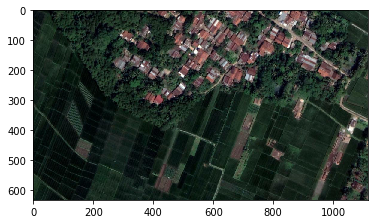

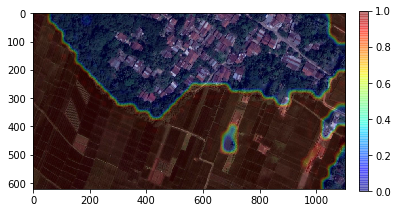

In [60]:
#Menampilkan hasil gambar level tertentu
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

#Menampilkan Luas Lahan Sawah yang berwarna Merah


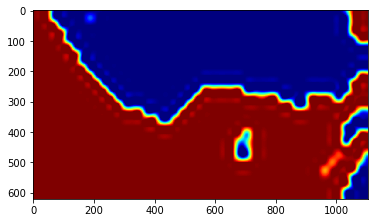

In [61]:
plt.imshow(zoomed,alpha=1,vmax=1.0,vmin=0,cmap="jet")

#Menghitung luas Sawah 


In [62]:
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed :", np.min(zoomed))
print("Maximal level zoomed :", np.max(zoomed))

Minimal level zoomed : -0.3082543
Maximal level zoomed : 1.2291265


In [63]:
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized = (zoomed-np.min(zoomed))/(np.max(zoomed)-np.min(zoomed))
print("Minimal level ternomalisasi:", np.min(normalized))
print("Maximal level ternomalisasi:", np.max(normalized))

Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


In [64]:
#Menghitung luas lahan sawah dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sawah adalah 0.5 (Nilai diantara 0 dan 1)
luaspiksel=(normalized>0.5).sum()
akurasi=((normalized>0.5).sum()*100/(normalized<1).sum())
print("Luas lahan sawah dalam piksel :", (luaspiksel))
print("akurasi dalam piksel :", (akurasi))

Luas lahan sawah dalam piksel : 399795
akurasi dalam piksel : 58.314602316568525


**"Validasi Nilai Piksel ke dalam Meter"**

![image](https://raw.githubusercontent.com/Gio1709/paddy/master/zoomed%20gambar.jpg)

Dapat dilakukan dengan cara :
1.   Menzoom/memperbesar sampel gambar (sampai batas maksimum).
2.   Menghitung jumlah piksel, sebagai contoh pada objek Bus. Diketahui pada umumnya Bus memiliki lebar sebesar 2,5 Meter. [Resolusi Gambar adalah 1116x632 piksel]
3.   Kalkulasi nilai lebar Bus dalam piksel, disini berjumlah 8 piksel. Lalu dilakukan perhitungan sebagai berikut :
    *   Nilai Meter/Piksel(**M/P**) = **M**(meter) / **P**(piksel)
                           = 2,5 meter / 8 piksel
                           = 0,3125 m/p 
                           ~= 0,3 m/p

Maka konversi 1 piksel menjadi meter pada gambar ini sebesar 0,3 

Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09



**Atau dengan pembanding validitas lainnya, yaitu menggunakan software Google Earth**

![image](https://raw.githubusercontent.com/Gio1709/paddy/master/google%20earth.jpg)

Disini diketahui :
*   Jumlah piksel pada garis berwarna kuning adalah 42 piksel
*   Panjang garis berwarna kuning adalah 14,5 meter

Dengan cara yang sama seprti sebelumnya :
 
 dilakukan perhitungan sebagai berikut :

    *   Nilai Meter/Piksel(M/P) = M(meter) / P(piksel)
                           = 14,5 meter / 42 piksel
                           = 0,323 m/p 
                           ~= 0,3 m/p

In [65]:
#Setelah diketahui luas sawah dalam piksel, kemudian menkonversi dalam meter dan hektar
#Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09 
luasmtr = 0.1089*(luaspiksel)
luasha = (luasmtr)/10000
print("Luas lahan sawah dalam meter persegi :", (luasmtr))
print("Luas lahan sawah dalam hektar :", (luasha))

Luas lahan sawah dalam meter persegi : 43537.6755
Luas lahan sawah dalam hektar : 4.35376755
